## Data Processing

Using data from Yahoo Finance

In [25]:
# Dependencies
import datetime as dt
import yfinance as yf

import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

In [13]:
# Define data range
company = '^FCHI'

start = dt.datetime(2015,1,1)
end = dt.datetime(2020,1,1)

In [14]:
# Load Data
data = yf.download(company, start = start, end=end)

[*********************100%%**********************]  1 of 1 completed


In [15]:
# Data info
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,4294.049805,4311.000000,4224.339844,4252.290039,4252.290039,69809300
2015-01-05,4221.990234,4276.919922,4105.450195,4111.359863,4111.359863,137887700
2015-01-06,4129.890137,4151.410156,4076.159912,4083.500000,4083.500000,130814400
2015-01-07,4111.729980,4144.950195,4080.780029,4112.729980,4112.729980,121316600
2015-01-08,4176.160156,4270.109863,4163.629883,4260.189941,4260.189941,154417100


In [16]:
# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [17]:
scaled_data.shape

(1277, 1)

In [18]:
# Create features
window_size = 30
features = [scaled_data[i:(i + window_size), 0] for i in range(0, len(scaled_data) - window_size)]
features = np.array(features)
labels = scaled_data[window_size:]

In [19]:
# Train test split
train_rng = int(features.shape[0]*0.8)
train_x = features[:train_rng]
train_y = labels[:train_rng]
test_x = features[train_rng:]
test_y = labels[train_rng:]

## Declare Model

In [20]:
# Make Kernel
kernel = DotProduct() + WhiteKernel()

In [21]:
# Make Model
model = GaussianProcessRegressor(kernel=kernel, random_state=42)

## Train Model

In [22]:
model.fit(train_x, train_y)

GaussianProcessRegressor(kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1),
                         random_state=42)

## Test Model

In [23]:
train_score = model.score(train_x, train_y)
test_score = model.score(test_x, test_y)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")

Train Score: 0.9834158751238536
Test Score: 0.9748696429097271


## Plot predictions

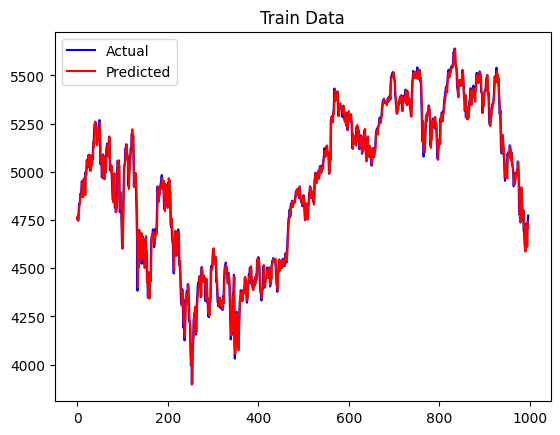

In [26]:
# Plot train results
train_pred = model.predict(train_x)
train_pred = scaler.inverse_transform(train_pred.reshape(-1, 1))
train_y = scaler.inverse_transform(train_y.reshape(-1, 1))

plt.plot(train_y, color='blue', label='Actual')
plt.plot(train_pred, color='red', label='Predicted')
plt.title('Train Data')
plt.legend()
plt.show()

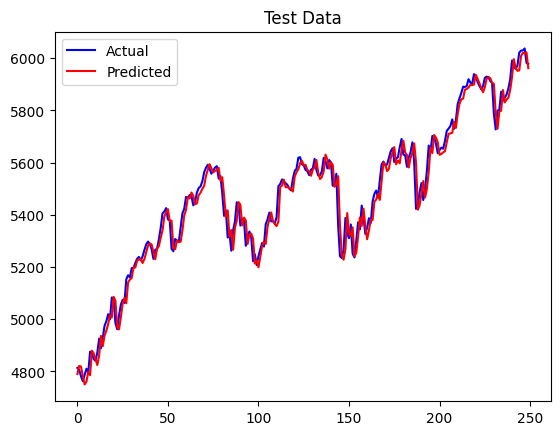

In [27]:
# Plot test results
test_pred = model.predict(test_x)
test_pred = scaler.inverse_transform(test_pred.reshape(-1, 1))
test_y = scaler.inverse_transform(test_y.reshape(-1, 1))

plt.plot(test_y, color='blue', label='Actual')
plt.plot(test_pred, color='red', label='Predicted')
plt.title('Test Data')
plt.legend()
plt.show()